<a href="https://colab.research.google.com/github/PeaceUdoka/Analysing_Market_Campaign_Perfomance/blob/main/Market_Analytics_with_Python_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Market Analytics

<ul>
    <li><a href="#overview">Overview</a></li>
    <li><a href="#fe-eng">Feature Engineering</a></li>
    <li><a href="#eda">Exploratory Analysis</a></li>
    <li><a href="#mktmetrics">Calculating Marketing Campaign Metrics</a></li>
    <li><a href="#segment">Customer Segmentation</a></li>
    <li><a href="#assess">Assessing Impact of Language Error on House Ads</a></li>
    <li><a href="#abtest">A/B Testing</a></li>
    <li><a href="#summary">Summary</a></li>
</ul>

## Overview
<a id='overview'></a>
The purpose of this analysis is to review marketing campaign performance. 

This is a guided project and is part of the DataCamp's course on Market Analytics.
The dataset was gotten from the DataCaamp classroom.



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

In [4]:
# Import data 
data = pd.read_csv('marketing.csv')

In [5]:
data.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
0,a100000029,1/1/18,House Ads,personalization,True,English,English,0-18 years,1/1/18,NaN,House Ads,True
1,a100000030,1/1/18,House Ads,personalization,True,English,English,19-24 years,1/1/18,NaN,House Ads,True
2,a100000031,1/1/18,House Ads,personalization,True,English,English,24-30 years,1/1/18,NaN,House Ads,True
3,a100000032,1/1/18,House Ads,personalization,True,English,English,30-36 years,1/1/18,NaN,House Ads,True
4,a100000033,1/1/18,House Ads,personalization,True,English,English,36-45 years,1/1/18,NaN,House Ads,True


In [6]:
data.describe()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
count,10037,10021,10022,10037,10022,10037,10037,10037,1856,577,1856,1856
unique,7309,31,5,2,2,4,4,7,31,115,5,2
top,a100000882,1/15/18,House Ads,control,False,English,English,19-24 years,1/16/18,4/2/18,Instagram,True
freq,12,789,4733,5091,8946,9793,9275,1682,163,15,600,1279


### Observations
1. The marketing campaigns were done in four different languages.
2. A greater number of users did not subscribe or convert.
3. The age_group between 19 - 24 years were most reached.
4. The top marketing channel is House Ads, and the top subscribing channel is Instagram.
5. Majority of the campaign was done in English.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              10037 non-null  object
 1   date_served          10021 non-null  object
 2   marketing_channel    10022 non-null  object
 3   variant              10037 non-null  object
 4   converted            10022 non-null  object
 5   language_displayed   10037 non-null  object
 6   language_preferred   10037 non-null  object
 7   age_group            10037 non-null  object
 8   date_subscribed      1856 non-null   object
 9   date_canceled        577 non-null    object
 10  subscribing_channel  1856 non-null   object
 11  is_retained          1856 non-null   object
dtypes: object(12)
memory usage: 941.1+ KB


### Observations
1. The date column is parsed as a string and not a datetime object.
2. The converted and is_retained columns have the wrong datatype.
3. The subscribing channel is in categories and can be represented with numerical values to aid in modelling.


In [8]:
# Import data and parse the date columns as datetime objects.
data = pd.read_csv('marketing.csv', parse_dates = ['date_served','date_subscribed','date_canceled'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              10037 non-null  object        
 1   date_served          10021 non-null  datetime64[ns]
 2   marketing_channel    10022 non-null  object        
 3   variant              10037 non-null  object        
 4   converted            10022 non-null  object        
 5   language_displayed   10037 non-null  object        
 6   language_preferred   10037 non-null  object        
 7   age_group            10037 non-null  object        
 8   date_subscribed      1856 non-null   datetime64[ns]
 9   date_canceled        577 non-null    datetime64[ns]
 10  subscribing_channel  1856 non-null   object        
 11  is_retained          1856 non-null   object        
dtypes: datetime64[ns](3), object(9)
memory usage: 941.1+ KB


In [9]:
data['converted'] = data['converted'].astype('bool')
data['is_retained'] = data['is_retained'].astype('bool')

In [10]:
data['is_retained'].dtype

dtype('bool')

## Feature Engineering

 <a id='fe-eng'></a>

<b> 1. Add a new column, channel_code, which maps the values in the subscribing_channel column to a numeric scale. </b>

In [11]:
# checking for unique channels
data['subscribing_channel'].unique()

array(['House Ads', 'Email', 'Push', 'Facebook', 'Instagram', nan],
      dtype=object)

In [12]:
# Mapping for channels
channel = {"House Ads": 1, "Email": 2, "Push": 3, "Facebook": 4,  "Instagram": 5}

# Map the channel to a channel code
data['channel_code'] = data['subscribing_channel'].map(channel)

## Exploratory Analysis
<a id='eda'></a>

<b> 1. What is the daily marketing reach? </b>

In [13]:
# groupby by date_served and count unique number of users
daily_reach = data.groupby('date_served')['user_id'].nunique()

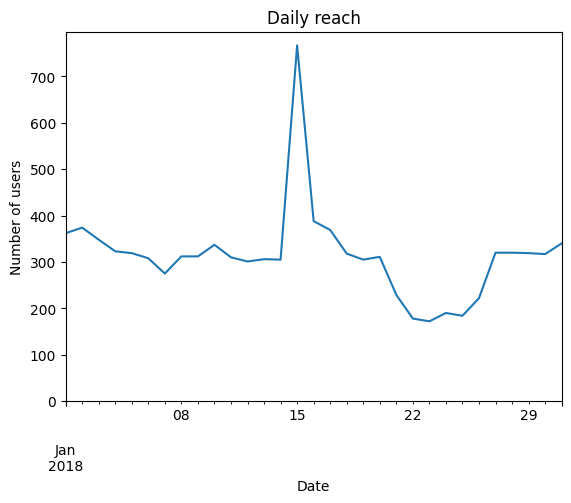

In [14]:
daily_reach.plot();
plt.title('Daily reach');
plt.ylabel('Number of users');
plt.xlabel('Date');
plt.ylim(0);

Notice that there is large peak in the middle of the month.

## Calculating Marketing Campaign Metrics
<a id ="mktmetrics"></a>
To determine how a camapaign performed, certain metrics will be calculated. They include:
- Conversion rate
- Retention rate

### Conversion Rate
This is the number of users that converted over the total number of users that were reached.

In [15]:
total = data['user_id'].nunique()
converted = data[data['converted']==True]['user_id'].nunique()
conversion_rate = round((converted*100/total),2)
print(f'The conversion rate is {conversion_rate}%')

The conversion rate is 14.09%


### Retention Rate
This is the number of users that remained subscribed over the total number of subscribers.

In [16]:
total_subscribers = data[data['converted']==True]['user_id'].nunique()
retained = data[data['is_retained']==True]['user_id'].nunique()
retention_rate = round((retained*100/total_subscribers),2)
print(f'The retention rate is {retention_rate}%')

The retention rate is 676.41%


To know if these rates are good enough, compare with historical data or competitor's rates.

## Customer Segmentation
<a id="segment"></a>
To make better decisions, let's analyse the campaign based on certain categories of people, grouped by: languages, age. Since majority of the campaign was done in English, let's start from there.
### Language Segment
<b> 1. How effective was the campaign on converting English speakers? </b>


In [17]:
eng_users = data[data["language_displayed"]=="English"]
total_eng_users = eng_users["user_id"].nunique()
eng_converted = eng_users[eng_users['converted']==True]["user_id"].nunique()
eng_conv_rate = round((eng_converted*100/total_eng_users),2)
print(f'The Conversion Rate for English Users is {eng_conv_rate}%')

The Conversion Rate for English Users is 13.13%


While many users preferred English, others preferred other languages.

<b> 2. How effective was the campaign in converting users of all four languages? </b>

In [18]:
# since we'll be doing a lot of conversion rate calculations, let's define a conversion rate function
def conv_rate(data,segment):
    # groupby segment and count number of users in all segments
    total = data.groupby(segment)['user_id'].nunique()
    
    # count number of users converted by language
    subscribers = data[data['converted']==True].groupby(segment)['user_id'].nunique()

    # calculate conversion rate 
    conv_rate = round((subscribers*100/total),2)
    
    return conv_rate

In [19]:
lang_conv_rate = conv_rate(data,'language_displayed')
lang_conv_rate

language_displayed
Arabic     50.00
English    13.13
German     71.62
Spanish    20.00
Name: user_id, dtype: float64

There appears to be much lower conversion of English and Spanish users than Arabic and German users. Let's plot this so we can see it better.

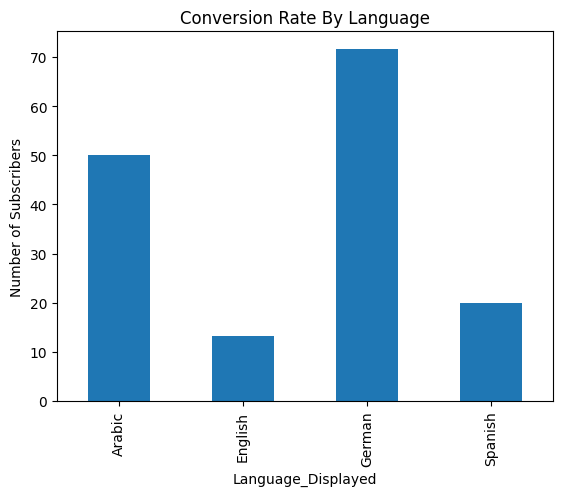

In [20]:
lang_conv_rate.plot(kind='bar');
plt.title('Conversion Rate By Language');
plt.ylabel('Number of Subscribers');
plt.xlabel('Language_Displayed');

### Date Segment

3. Is there a difference in the conversion rates based on when in the month the users saw an ad?

In [21]:
daily_conv_rate = conv_rate(data,'date_served')
daily_conv_rate = pd.DataFrame(daily_conv_rate.reset_index())
daily_conv_rate.columns = ['date_served', 'conversion_rate']

daily_conv_rate.head()

,date_served,conversion_rate
0,2018-01-01,9.94
1,2018-01-02,9.89
2,2018-01-03,10.34
3,2018-01-04,10.84
4,2018-01-05,12.54


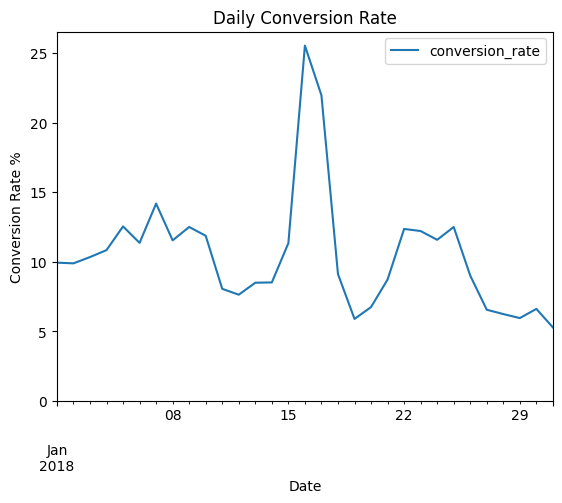

In [22]:
#plot to see trend
daily_conv_rate.plot('date_served','conversion_rate');
plt.title('Daily Conversion Rate');
plt.ylabel('Conversion Rate %');
plt.xlabel('Date');
plt.ylim(0);

Similar to the daily marketing reach, there is a spike in conversion rate in the middle of the month.

<b> 4. What is the daily retention rate?

In [23]:
# let's define a retention rate function
def retention_rate(data,segment):
    # groupby segment and count number of users in all segments
    total = data.groupby(segment)['user_id'].nunique()
    
    # count number of users converted by language
    subscribers = data[data['is_retained']==True].groupby(segment)['user_id'].nunique()

    # calculate conversion rate 
    ret_rate = round((subscribers*100/total),2)
    
    return ret_rate

In [24]:
daily_retention_rate = retention_rate(data,'date_subscribed')
daily_retention_rate = pd.DataFrame(daily_retention_rate.reset_index())
daily_retention_rate.columns = ['date_subscribed', 'retention_rate']

daily_retention_rate.head()

,date_subscribed,retention_rate
0,2018-01-01,77.78
1,2018-01-02,70.27
2,2018-01-03,72.97
3,2018-01-04,50.00
4,2018-01-05,57.50


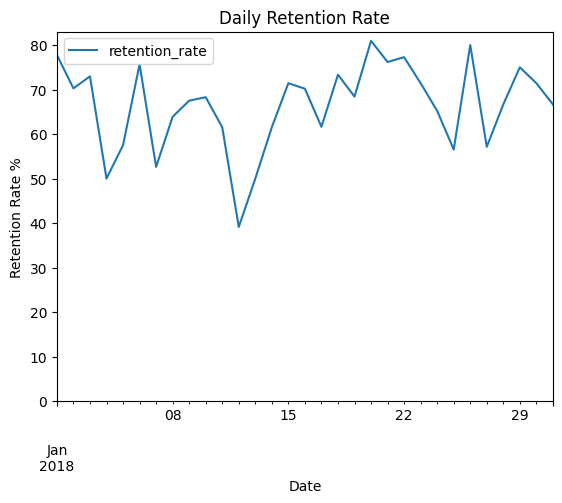

In [25]:
#plot to see trend
daily_retention_rate.plot('date_subscribed','retention_rate');
plt.title('Daily Retention Rate');
plt.ylabel('Retention Rate %');
plt.xlabel('Date');
plt.ylim(0);

There is a relatively steady retention rate through the month.

### Age Demographics
<b> 5. How did the marketing channels reach users of different age groups?

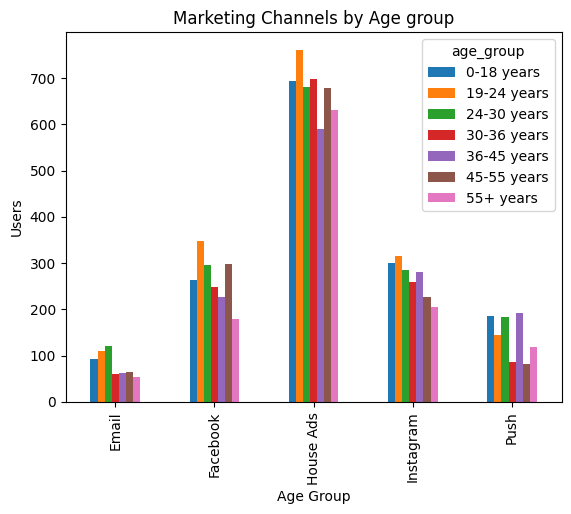

In [26]:
# groupby channel and age and count total number of users
users_by_channel_age = data.groupby(['marketing_channel','age_group'])['user_id'].count()
users_by_channel_age = pd.DataFrame(users_by_channel_age.unstack(level=1))
# Plot to visualize
users_by_channel_age.plot(kind = 'bar')
plt.title('Marketing Channels by Age group');
plt.xlabel('Age Group');
plt.ylabel('Users');
# Add a legend to the plot
#plt.legend(loc = 'upper right',labels = users_by_channel_age.columns.values);

### Channels Performance

<b> 6. What is the conversion rate per Marketing channel? 

In [27]:
daily_conv_rate_by_channel = conv_rate(data,['date_served','marketing_channel'])
daily_conv_rate_by_channel = pd.DataFrame(daily_conv_rate_by_channel.unstack(level=1))
daily_conv_rate_by_channel.head()

marketing_channel,Email,Facebook,House Ads,Instagram,Push
date_served,,,,,
2018-01-01,100.0,11.76,8.47,10.67,8.33
2018-01-02,100.0,9.84,7.80,12.90,5.56
2018-01-03,NaN,8.06,8.85,17.19,8.33
2018-01-04,50.0,13.85,8.98,12.70,5.88
2018-01-05,100.0,11.29,12.66,15.94,2.78


In [28]:
def plotting_conv(dataframe):
    for column in dataframe:
        plt.plot(dataframe.index,dataframe[column])

        plt.title('Daily '+str(column)+' Conversion Rate');
        
        plt.ylabel('Conversion Rate (%)');
        plt.xticks(rotation = 45);
        plt.ylim(0)
        plt.show()

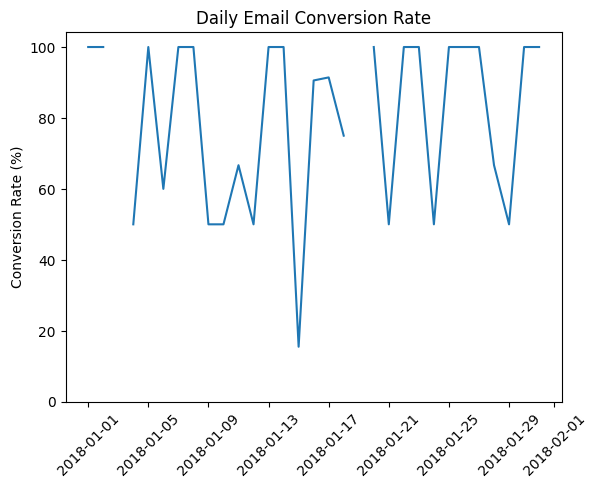

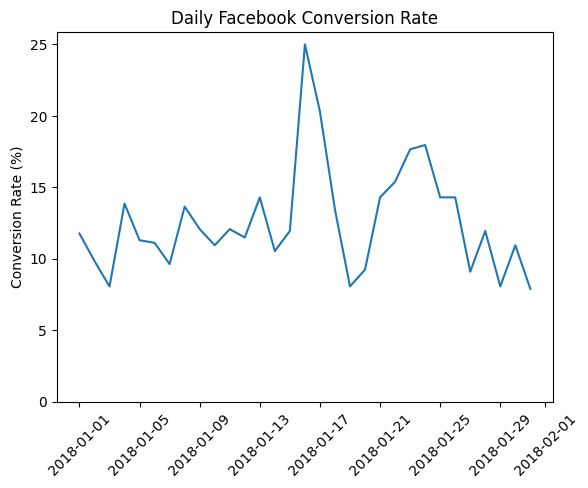

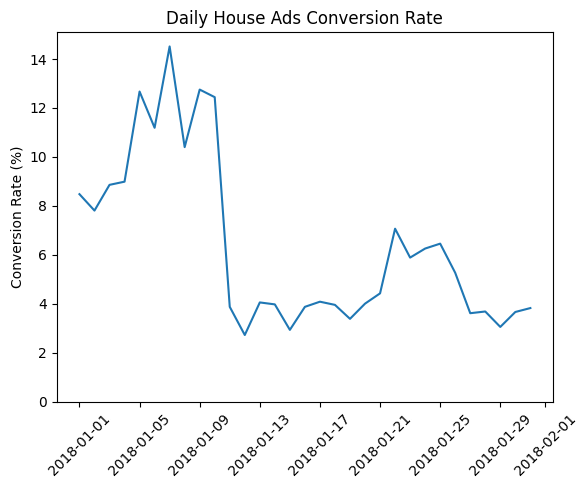

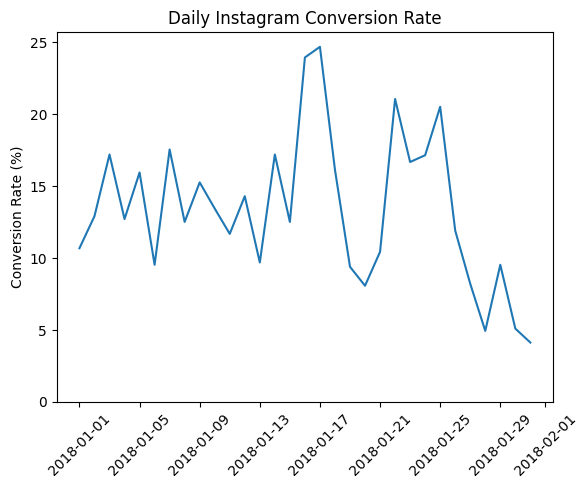

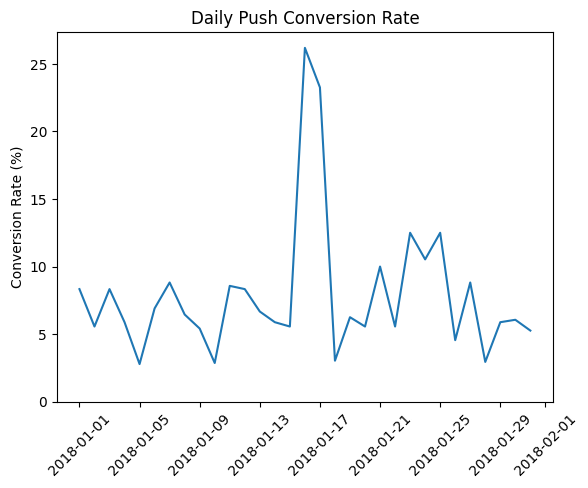

In [29]:
plotting_conv(daily_conv_rate_by_channel)


<b> Observations </b>
1. There is a downward spike in Email conversions in the middle of the month. 
2. There is an upward spike in Facebook and Push conversions in the middle of the month.
3. The conversion rates for House Ads decreased from the middle of the month to the end of the month.
4. The Conversion Rate for Instagram shows a relatively steady slope.


<b> 7. What is the retention rate per Marketing channel? 

In [30]:
daily_ret_rate_by_channel = retention_rate(data,['date_subscribed','marketing_channel'])
daily_ret_rate_by_channel = pd.DataFrame(daily_ret_rate_by_channel.unstack(level=1))
daily_ret_rate_by_channel.head()

marketing_channel,Email,Facebook,House Ads,Instagram,Push
date_subscribed,,,,,
2018-01-01,100.0,90.91,69.57,83.33,100.00
2018-01-02,75.0,81.82,65.52,72.73,85.71
2018-01-03,NaN,77.78,67.86,91.67,40.00
2018-01-04,50.0,50.00,53.85,45.45,NaN
2018-01-05,100.0,66.67,48.39,61.54,100.00


In [31]:
def plotting_ret(dataframe):
    for column in dataframe:
        plt.plot(dataframe.index,dataframe[column])

        plt.title('Daily '+str(column)+' Retention Rate');
        plt.xlabel('Date');
        plt.ylabel('Conversion Rate (%)');
        plt.xticks(rotation = 45);
        plt.ylim(0)
        plt.show()

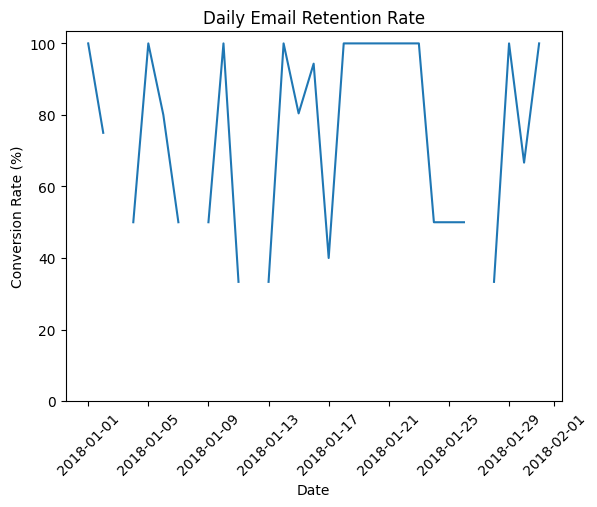

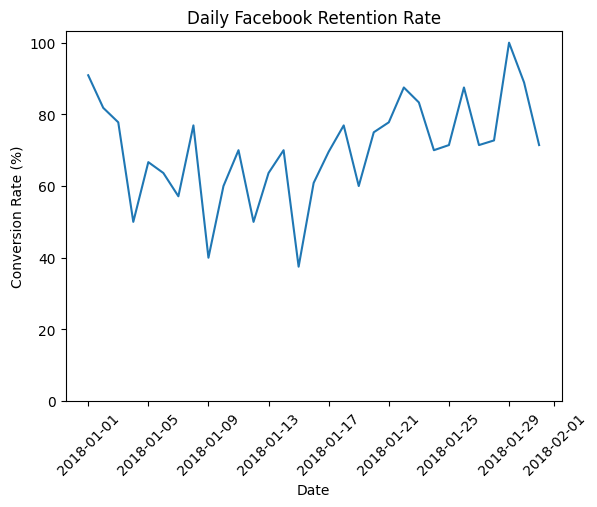

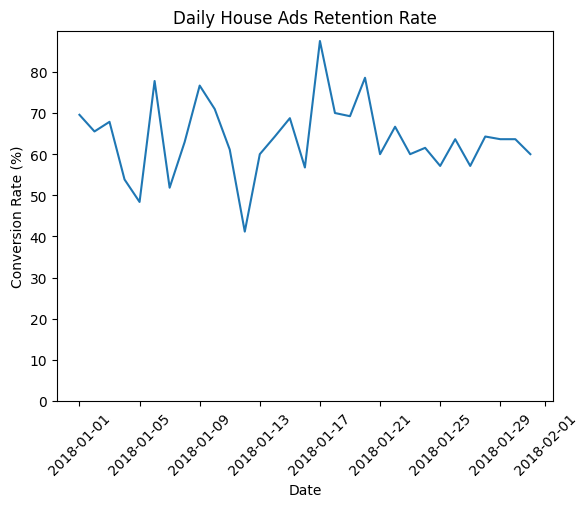

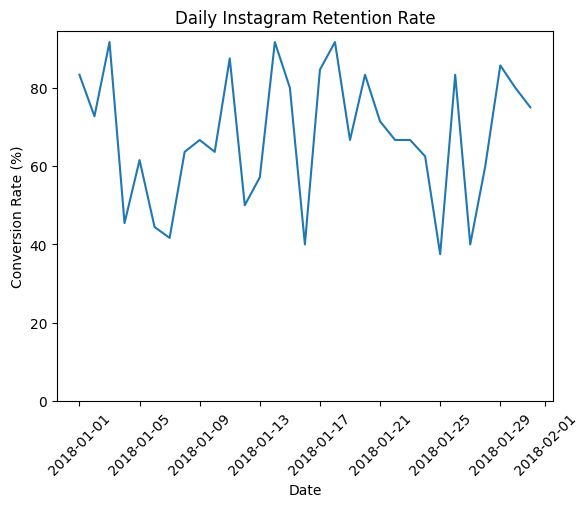

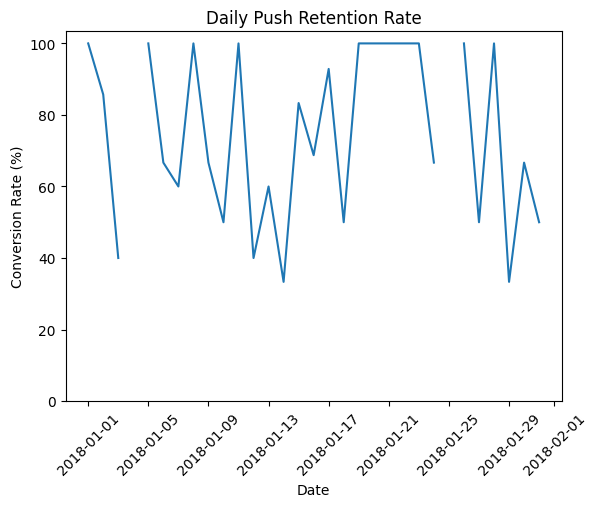

In [32]:
plotting_ret(daily_ret_rate_by_channel)

From the observations from 6 above, note that the House Ads campaign showed a decline in conversion rates from the middle of the month to the end of the month. Let's take a closer look at this.

In [33]:
daily_conv_rate_by_channel['House Ads']

date_served
2018-01-01     8.47
2018-01-02     7.80
2018-01-03     8.85
2018-01-04     8.98
2018-01-05    12.66
2018-01-06    11.18
2018-01-07    14.50
2018-01-08    10.39
2018-01-09    12.74
2018-01-10    12.43
2018-01-11     3.87
2018-01-12     2.72
2018-01-13     4.05
2018-01-14     3.97
2018-01-15     2.93
2018-01-16     3.87
2018-01-17     4.08
2018-01-18     3.95
2018-01-19     3.38
2018-01-20     4.00
2018-01-21     4.42
2018-01-22     7.06
2018-01-23     5.88
2018-01-24     6.25
2018-01-25     6.45
2018-01-26     5.26
2018-01-27     3.61
2018-01-28     3.68
2018-01-29     3.05
2018-01-30     3.66
2018-01-31     3.82
Name: House Ads, dtype: float64

Notice that the decline started from the 11th of January. Let's check if this decline is due to expected shifts in user behavior (i.e., differences across the day of the week)

<b> Conversion rate by Day of Week

In [34]:
data['DOW_served'] = data['date_served'].dt.dayofweek

In [35]:
house_ads = data[data['marketing_channel']=='House Ads']
dow_conv = conv_rate(house_ads,['DOW_served', 'marketing_channel'])
dow_conv = pd.DataFrame(dow_conv.unstack(level=1))
dow_conv

marketing_channel,House Ads
DOW_served,
0.0,6.27
1.0,7.03
2.0,7.53
3.0,5.90
4.0,6.23
5.0,5.76
6.0,6.52


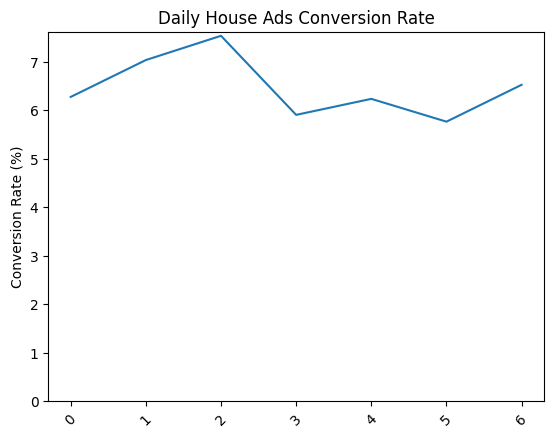

In [36]:
plotting_conv(dow_conv)


There is relatively no difference conversion Rate per day of week for House Ads 

<b> Conversion Rate By Language

In [37]:
lang_conv = conv_rate(house_ads,['date_served','language_displayed'])
lang_conv = pd.DataFrame(lang_conv.unstack(level=1))
lang_conv

language_displayed,Arabic,English,German,Spanish
date_served,,,,
2018-01-01,100.0,7.51,20.00,NaN
2018-01-02,NaN,6.90,60.00,NaN
2018-01-03,NaN,8.38,33.33,12.50
2018-01-04,NaN,8.05,NaN,21.43
2018-01-05,NaN,11.89,NaN,21.43
2018-01-06,100.0,8.76,NaN,20.00
2018-01-07,100.0,11.76,100.00,12.50
2018-01-08,NaN,7.97,50.00,20.00
2018-01-09,NaN,12.93,NaN,10.00


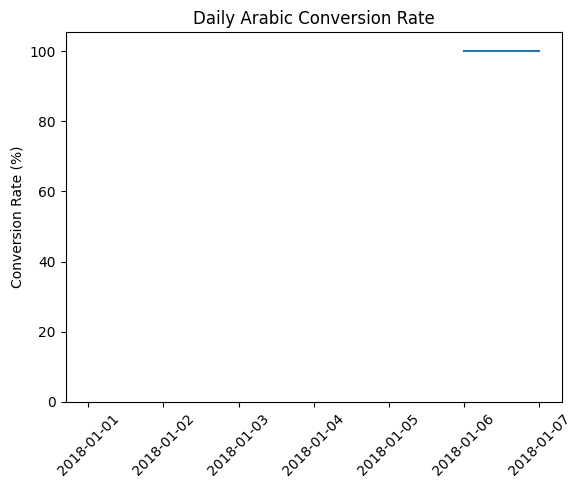

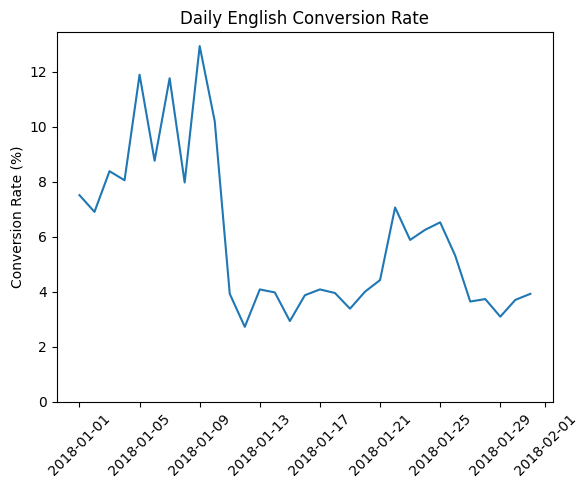

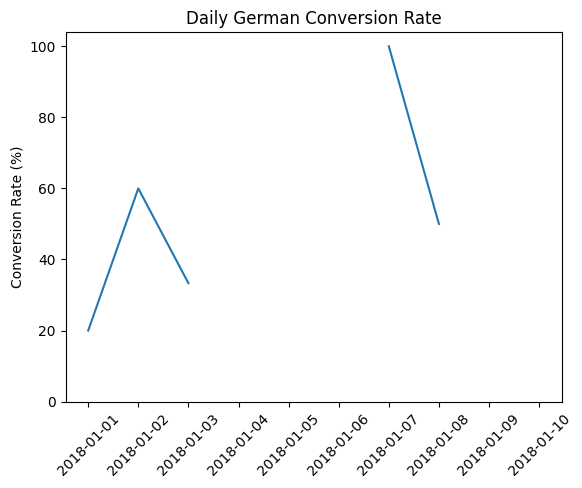

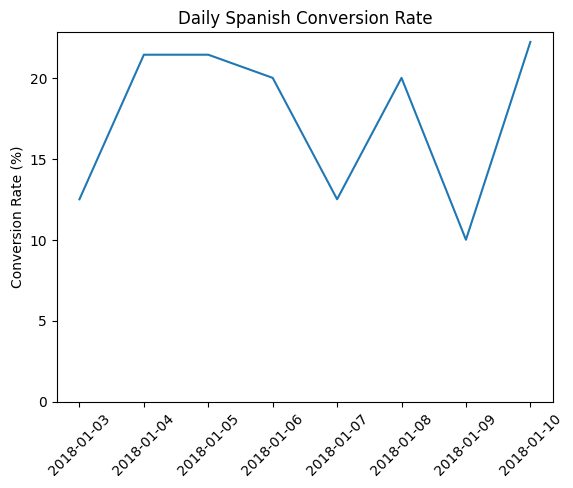

In [38]:
plotting_conv(lang_conv)

Eureka!!! The English conversion rate drops around the 11th, but there seems to be no ads served in other languages for most days. This shows a pattern around language preferences.

For further investigation, let's check if the language displayed is same as the language preferred for the House Ads.

In [39]:
house_ads['is_same_lang'] = np.where(house_ads['language_displayed']==house_ads['language_preferred'], 'Yes', 'No')

<ipython-input-39-54e1657e6701>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_ads['is_same_lang'] = np.where(house_ads['language_displayed']==house_ads['language_preferred'], 'Yes', 'No')


In [40]:
lang_check = house_ads.groupby(['date_served','is_same_lang'])['user_id'].count()
lang_check = pd.DataFrame(lang_check.unstack(level=1)).fillna(0)
lang_check

is_same_lang,No,Yes
date_served,,
2018-01-01,2.0,189.0
2018-01-02,3.0,247.0
2018-01-03,0.0,220.0
2018-01-04,0.0,168.0
2018-01-05,0.0,160.0
2018-01-06,1.0,151.0
2018-01-07,2.0,130.0
2018-01-08,0.0,154.0
2018-01-09,0.0,157.0


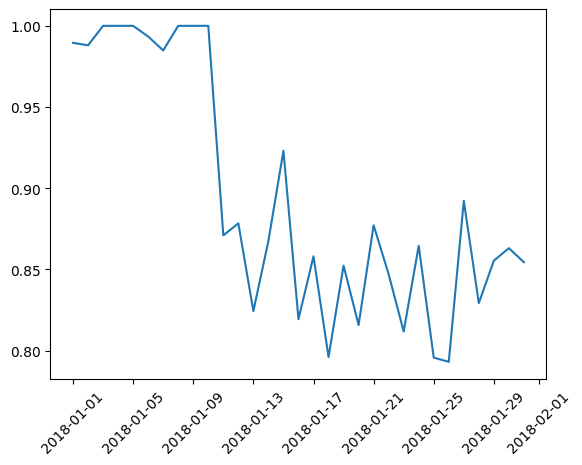

In [41]:
lang_check['pct'] = lang_check['Yes']/lang_check.sum(axis=1)

# Plot and show your results
plt.plot(lang_check.index.values, lang_check['pct']);
plt.xticks(rotation=45);

This shows that the percentage where the language displayed is not same as the language preferred occurs from the 11th which is also around the time where the decline in House Ads occured.

Now that we know that the reason for the decline in House Ads is because of the language difference, let's see how many users we lost as a result of this.

### Assesing Impact of Language Error on House Ads
<a id="assess"></a>

In [42]:
# slice house ads df to the time before the decline started
house_ads_bug = house_ads[house_ads['date_served']<'2018-01-11']
lang_conv = conv_rate(house_ads_bug,["language_displayed"])
lang_conv

language_displayed
Arabic     50.00
English     9.91
German     44.44
Spanish    16.67
Name: user_id, dtype: float64

In [43]:
#get the ratio of conversion of each language to English
arabic_ratio = lang_conv['Arabic']/lang_conv['English']
german_ratio = lang_conv['German']/lang_conv['English']
spanish_ratio = lang_conv['Spanish']/lang_conv['English']

In [44]:
# Group house_ads by date and language
converted = house_ads.groupby(['date_served','language_preferred']).agg({'user_id':'nunique','converted':'sum'})

# Unstack converted
converted = pd.DataFrame(converted.unstack(level=1))

In [45]:
# Create English conversion rate column for affected period
converted['english_conv_rate'] = converted.loc['2018-01-11':'2018-01-31'][('converted','English')]

# Create expected conversion rates for each language
converted['expected_arabic_rate'] = converted['english_conv_rate']*arabic_ratio
converted['expected_german_rate'] = converted['english_conv_rate']*german_ratio
converted['expected_spanish_rate'] = converted['english_conv_rate']*spanish_ratio

# Multiply number of users by the expected conversion rate
converted['expected_arabic_conv'] = converted[('user_id','Arabic')]*converted['expected_arabic_rate']/100
converted['expected_german_conv'] = converted[('user_id','German')]*converted['expected_german_rate']/100
converted['expected_spanish_conv'] = converted[('user_id','Spanish')]*converted['expected_spanish_rate']/100

converted.head()

user_id                        converted                 \
language_preferred  Arabic English German Spanish    Arabic English German   
date_served                                                                  
2018-01-01             2.0   171.0    5.0    11.0       2.0    13.0    1.0   
2018-01-02             3.0   200.0    5.0    10.0       0.0    14.0    3.0   
2018-01-03             2.0   179.0    3.0     8.0       0.0    15.0    1.0   
2018-01-04             2.0   149.0    2.0    14.0       0.0    12.0    0.0   
2018-01-05             NaN   143.0    1.0    14.0       NaN    17.0    0.0   

                           english_conv_rate expected_arabic_rate  \
language_preferred Spanish                                          
date_served                                                         
2018-01-01             0.0               NaN                  NaN   
2018-01-02             0.0               NaN                  NaN   
2018-01-03             1.0               NaN                  NaN   
2018-01-04             3.0               NaN                  NaN   
2018-01-05             3.0               NaN                  NaN   

                   expected_german_rate expected_spanish_rate  \
language_preferred                                              
date_served                                                     
2018-01-01                          NaN                   NaN   
2018-01-02                          NaN                   NaN   
2018-01-03                          NaN                   NaN   
2018-01-04                          NaN                   NaN   
2018-01-05                          NaN                   NaN   

                   expected_arabic_conv expected_german_conv  \
language_preferred                                             
date_served                                                    
2018-01-01                          NaN                  NaN   
2018-01-02                          NaN                  NaN   
2018-01-03                          NaN                  NaN   
2018-01-04                          NaN                  NaN   
2018-01-05                          NaN                  NaN   

                   expected_spanish_conv  
language_preferred                        
date_served                               
2018-01-01                           NaN  
2018-01-02                           NaN  
2018-01-03                           NaN  
2018-01-04                           NaN  
2018-01-05                           NaN

In [46]:
# slice only the relevant dates
converted = converted.loc['2018-01-11':'2018-01-31']

# Sum expected subscribers for each language
expected_subs = converted['expected_spanish_conv'].sum() + converted['expected_arabic_conv'].sum() + converted['expected_german_conv'].sum()

# Calculate how many subscribers we actually got
actual_subs = converted[('converted','Spanish')].sum() + converted[('converted','Arabic')].sum() + converted[('converted','German')].sum()

# Subtract how many subscribers we got despite the bug
lost_subs = expected_subs-actual_subs
lost_subs

32.14250252270434

Due to the language error, 32 subscribers were lost.

## A/B Testing
<a id='abtest'></a>

FRom background information, the Email campaign was run as an A/B test.
Half the emails sent out were generic upsells to the product while the other half contained personalized messaging around the users’ usage of the site.

Before analyzing the results, let's check to ensure users were allocated equally to the test and control groups.

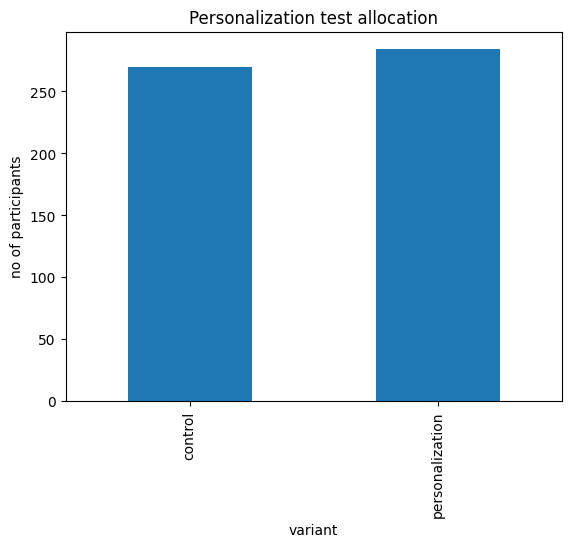

In [47]:
email = data[data['marketing_channel']=='Email']

# Group the email DataFrame by variant 
alloc = email.groupby('variant')['user_id'].nunique()

# Plot a bar chart of the test allocation
alloc.plot(kind='bar')
plt.title('Personalization test allocation');
plt.ylabel('no of participants');


There is not much difference so let's forge ahead.
### Comparing Conversion Rates in both Control and Test Groups

In [48]:
# Group marketing by user_id and variant
subscribers = email.groupby(['user_id','variant'])['converted'].max()
subscribers = pd.DataFrame(subscribers.unstack(level=1)) 

# Drop missing values from the control column
control = subscribers['control'].dropna()

# Drop missing values from the personalization column
personalization = subscribers['personalization'].dropna()

print('Control conversion rate:', np.mean(control))
print('Personalization conversion rate:',np.mean(personalization))

Control conversion rate: 0.2814814814814815
Personalization conversion rate: 0.3908450704225352


In [49]:
control

user_id
a100000687    False
a100000688     True
a100000689     True
a100000690     True
a100000691     True
              ...  
a100007288     True
a100007289     True
a100007290     True
a100007291     True
a100007293     True
Name: control, Length: 270, dtype: object

The test group(personlization) recorded more conversion rate than the control group.
### Calculating the Lift

Lift is the percent difference between the control and treatment.


In [50]:
def lift(a,b):
    # Calcuate the mean of a and b
    a_mean = np.mean(a)
    b_mean = np.mean(b)
    
    # Calculate the lift using a_mean and b_mean
    lift = (b_mean-a_mean)/a_mean
  
    return str(round(lift*100, 2)) + '%'
  
# Print lift() with control and personalization as inputs
lift(control, personalization)

'38.85%'

This shows that the personalised group conversion rate is higher than the control group by 38.85%.

But is this difference significant?

In [51]:
control = control.astype('float')

In [52]:
personalization = personalization.astype('float')

In [53]:
t = stats.ttest_ind(control,personalization)
t

Ttest_indResult(statistic=-2.734329944750507, pvalue=0.006451487844694182)

Since the p value is way less than 0.05, the difference between the conversion rate of the control and personalization groups is <b>highly significant.</b>

Let's check if this holds true across all demographics.

### A/B Testing By Segments

Let's define a function for this to avvoid repitition.

In [54]:
def ab_segmentation(segment):
    # Build a for loop for each subsegment in marketing
    for subsegment in np.unique(data[segment].values):
        print(subsegment)
      
        # Limit marketing to email and subsegment
        email = data[(data['marketing_channel'] == 'Email') & (data[segment] == subsegment)]

        subscribers = email.groupby(['user_id', 'variant'])['converted'].max()
        subscribers = pd.DataFrame(subscribers.unstack(level=1)) 
        control = subscribers['control'].dropna()
        personalization = subscribers['personalization'].dropna()

        print('lift:', lift(control,personalization)) 
        control = control.astype('float')
        personalization = personalization.astype('float')
        print('t-statistic:', stats.ttest_ind(control,personalization), '\n\n')

### By Age Group

In [55]:
ab_segmentation('age_group')

0-18 years
lift: 121.4%
t-statistic: Ttest_indResult(statistic=-2.966044912142212, pvalue=0.003872449439129706) 


19-24 years
lift: 106.24%
t-statistic: Ttest_indResult(statistic=-3.0317943847866697, pvalue=0.0030623836114689195) 


24-30 years
lift: 161.19%
t-statistic: Ttest_indResult(statistic=-3.861539544326876, pvalue=0.00018743381094867337) 


30-36 years
lift: -100.0%
t-statistic: Ttest_indResult(statistic=3.185906464414798, pvalue=0.0023238487431765337) 


36-45 years
lift: -85.23%
t-statistic: Ttest_indResult(statistic=2.431790127931851, pvalue=0.017975686009788255) 


45-55 years
lift: -72.22%
t-statistic: Ttest_indResult(statistic=2.0654991273179326, pvalue=0.04306233968820123) 


55+ years
lift: -100.0%
t-statistic: Ttest_indResult(statistic=3.326565456420339, pvalue=0.0016358623456360468) 




The personalization was highly effective for the younger groups than for the older groups.

In [56]:
ab_segmentation('language_displayed')

Arabic
lift: 50.0%
t-statistic: Ttest_indResult(statistic=-0.5773502691896255, pvalue=0.5795840000000001) 


English
lift: 39.0%
t-statistic: Ttest_indResult(statistic=-2.2183598646203215, pvalue=0.026991701290720503) 


German
lift: -1.62%
t-statistic: Ttest_indResult(statistic=0.19100834180787182, pvalue=0.8494394170062678) 


Spanish
lift: 166.67%
t-statistic: Ttest_indResult(statistic=-2.3570226039551585, pvalue=0.040156718110477524) 




<ipython-input-54-a3cf0c964f50>:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print('t-statistic:', stats.ttest_ind(control,personalization), '\n\n')


The personalization was more effective for the Spanish and English users and not effective for the Arabic and German users.

## Summary
<a id='summary'></a>

1. The team should ensure that the language a user sees a house ad in is the same as the language the user prefers. This error had cost the business 32 subscribers and a massive reduction in the conversion and retention rate and hence should be avoided.

2. The Email campaign produced effective results for the younger age group and for English and Spanish speakers.